In [2]:
import transformers
print(transformers.__version__)


4.51.3


In [3]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead.")

GPU is available and being used: NVIDIA GeForce RTX 3070


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import torch

In [5]:
english_path = 'preprocessed_english_1.csv'
bangla_path  = 'preprocessed_bangla_1.csv'

In [6]:
import pandas as pd

df_english = pd.read_csv(english_path, encoding='latin-1')
df_bangla  = pd.read_csv(bangla_path)

print("English Dataset:", df_english.shape)
print("Bangla Dataset:", df_bangla.shape)
df_english.head()
df_bangla.head()


English Dataset: (28247, 3)
Bangla Dataset: (24341, 3)


,comments,label,cleaned_text
0,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,not bully,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...
1,"অরে বাবা, এই টা কোন পাগল????",not bully,"অরে বাবা, এই টা কোন পাগল????"
2,ক্যাপ্টেন অফ বাংলাদেশ,not bully,ক্যাপ্টেন অফ বাংলাদেশ
3,অন্যরকম .. ভালো লাগলো ..❤️,not bully,অন্যরকম .. ভালো লাগলো ..redheart
4,মোহাম্মদ কফিল উদ্দীন মাহমুদRidwan RomelDwaipay...,not bully,মোহাম্মদ কফিল উদ্দীন মাহমুদridwan romeldwaipay...


C:\Users\MIST LAB\AppData\Local\Temp\ipykernel_4644\431278814.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="muted")


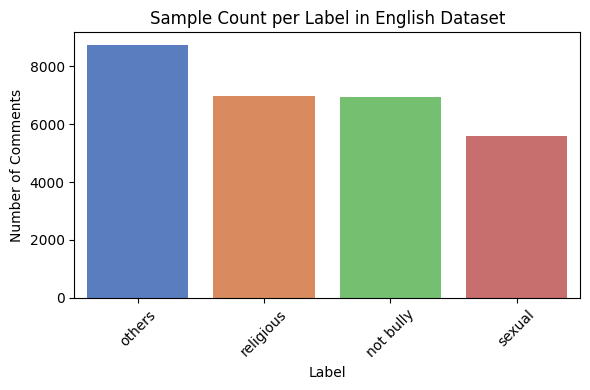

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count samples for each label in English dataset
label_counts = df_english['label'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="muted")
plt.title('Sample Count per Label in English Dataset')
plt.xlabel('Label')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\MIST LAB\AppData\Local\Temp\ipykernel_4644\2498702705.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="muted")


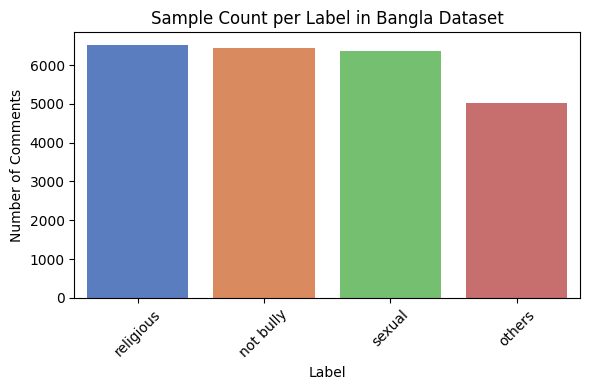

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count samples for each label in English dataset
label_counts = df_bangla['label'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="muted")
plt.title('Sample Count per Label in Bangla Dataset')
plt.xlabel('Label')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
label_counts
#print(type(label_counts))

label
religious    6516
not bully    6441
sexual       6372
others       5012
Name: count, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

# Perform stratified split
b_train_df, b_test_df = train_test_split(
    df_bangla,
    test_size=0.2,
    stratify=df_bangla['label'],  # preserve label distribution
    random_state=42
)

# Optional: Check shape
print("Training set shape:", b_train_df.shape)
print("Testing set shape:", b_test_df.shape)

# Optional: Check distribution
print("\nTraining set label distribution:\n", b_train_df['label'].value_counts(normalize=False))
print("\nTesting set label distribution:\n", b_test_df['label'].value_counts(normalize=True))


Training set shape: (19472, 3)
Testing set shape: (4869, 3)

Training set label distribution:
 label
religious    5213
not bully    5153
sexual       5097
others       4009
Name: count, dtype: int64

Testing set label distribution:
 label
religious    0.267611
not bully    0.264531
sexual       0.261861
others       0.205997
Name: proportion, dtype: float64


In [11]:
from sklearn.model_selection import train_test_split

# Perform stratified split
e_train_df, e_test_df = train_test_split(
    df_english,
    test_size=0.2,
    stratify=df_english['label'],  # preserve label distribution
    random_state=42
)

# Optional: Check shape
print("Training set shape:", e_train_df.shape)
print("Testing set shape:", e_test_df.shape)

# Optional: Check distribution
print("\nTraining set label distribution:\n", e_train_df['label'].value_counts(normalize=False))
print("\nTesting set label distribution:\n", e_test_df['label'].value_counts(normalize=True))


Training set shape: (22597, 3)
Testing set shape: (5650, 3)

Training set label distribution:
 label
others       6990
religious    5591
not bully    5549
sexual       4467
Name: count, dtype: int64

Testing set label distribution:
 label
others       0.309381
religious    0.247434
not bully    0.245487
sexual       0.197699
Name: proportion, dtype: float64


In [12]:
import pandas as pd

train_df = pd.concat([e_train_df, b_train_df], ignore_index=True)
test_df = pd.concat([e_test_df, b_test_df], ignore_index=True)

print("Combined Training set shape:", train_df.shape)
print("Combined Testing set shape:", test_df.shape)

print("\nCombined Training set label distribution:\n", train_df['label'].value_counts())
print("\nCombined Testing set label distribution:\n", test_df['label'].value_counts())


Combined Training set shape: (42069, 3)
Combined Testing set shape: (10519, 3)

Combined Training set label distribution:
 label
others       10999
religious    10804
not bully    10702
sexual        9564
Name: count, dtype: int64

Combined Testing set label distribution:
 label
others       2751
religious    2701
not bully    2675
sexual       2392
Name: count, dtype: int64


In [13]:
# Get unique classes and sort for consistency
classes = sorted(train_df['label'].unique())

# Create mappings
class_to_id = {cls: idx for idx, cls in enumerate(classes)}
id_to_class = {idx: cls for cls, idx in class_to_id.items()}

# Map original labels to IDs
train_df['label_id'] = train_df['label'].map(class_to_id)

# Preview
print("Class to ID mapping:", class_to_id)
print(train_df[['label', 'label_id']].head())


Class to ID mapping: {'not bully': 0, 'others': 1, 'religious': 2, 'sexual': 3}
       label  label_id
0  not bully         0
1  religious         2
2  religious         2
3     others         1
4     others         1


In [14]:
# Get unique classes and sort for consistency
classes = sorted(test_df['label'].unique())

# Create mappings
class_to_id = {cls: idx for idx, cls in enumerate(classes)}
id_to_class = {idx: cls for cls, idx in class_to_id.items()}

# Map original labels to IDs
test_df['label_id'] = test_df['label'].map(class_to_id)

# Preview
print("Class to ID mapping:", class_to_id)
print(test_df[['label', 'label_id']].head())


Class to ID mapping: {'not bully': 0, 'others': 1, 'religious': 2, 'sexual': 3}
       label  label_id
0  religious         2
1     others         1
2  not bully         0
3  religious         2
4  religious         2


In [15]:
import numpy as np

# From training DataFrame
train_texts = np.array(train_df['cleaned_text'].values)
train_labels = np.array(train_df['label'].values)

# From test DataFrame
test_texts = np.array(test_df['cleaned_text'].values)
test_labels = np.array(test_df['label'].values)


In [16]:
print(type(train_texts))   # <class 'list'>
print(type(train_labels))  # <class 'list'>

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [17]:
# Step 1: Get all unique classes from the full dataset
all_classes = sorted(df_english['label'].unique())  # use sorted for consistent ID order

# Step 2: Create class-to-id and id-to-class mappings
class_to_id = {cls: idx for idx, cls in enumerate(all_classes)}
id_to_class = {idx: cls for cls, idx in class_to_id.items()}

# Step 3: Apply the mapping to both train and test DataFrames
train_df['label_id'] = train_df['label'].map(class_to_id)
test_df['label_id'] = test_df['label'].map(class_to_id)

# Step 4: Check mappings
print("Class to ID mapping:", class_to_id)
print(train_df[['label', 'label_id']].head())


Class to ID mapping: {'not bully': 0, 'others': 1, 'religious': 2, 'sexual': 3}
       label  label_id
0  not bully         0
1  religious         2
2  religious         2
3     others         1
4     others         1


In [18]:


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased",
    num_labels=4  # Change based on your task
)


# Tokenize the text
def tokenize_function(texts):
    # Ensure all elements are strings
    texts = [str(text) for text in texts]  # Convert each element to string explicitly
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_function(train_texts)
test_encodings = tokenize_function(test_texts)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

G:\Python\Python310\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MIST LAB\.cache\huggingface\hub\models--distilbert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:


# Choose one comment
sample_text = train_texts[0]  # or any index

# Tokenize with padding, truncation, and special tokens
encoded = tokenizer.encode_plus(
    sample_text,
    padding='max_length',
    truncation=True,
    max_length=20,  # use a small max_length to clearly see [PAD]
    return_tensors="pt"
)

# Convert input_ids to tokens
tokens = tokenizer.convert_ids_to_tokens(encoded['input_ids'][0])

# Decode back to text (includes [CLS], [SEP], not [PAD])
decoded_text = tokenizer.decode(encoded['input_ids'][0])

# Display
print(f"Original Text: {sample_text}")
print(f"\nTokenized Text (decoded): {decoded_text}")
print(f"\nTokens: {tokens}")


Original Text: fuck off i can't watch another round mkr

Tokenized Text (decoded): [CLS] fuck off i can't watch another round mkr [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Tokens: ['[CLS]', 'fu', '##ck', 'off', 'i', 'can', "'", 't', 'watch', 'another', 'round', 'mk', '##r', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [20]:
# Create a custom dataset class
class CyberbullyingDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [21]:
# Label mapping
label2id = {'not bully': 0, 'religious': 1, 'others': 2, 'sexual': 3}

# Convert labels to integers
train_labels = [label2id[label] for label in train_labels]
test_labels = [label2id[label] for label in test_labels]

# Create datasets
train_dataset = CyberbullyingDataset(train_encodings, train_labels)
test_dataset = CyberbullyingDataset(test_encodings, test_labels)


In [22]:
train_dataset = CyberbullyingDataset(train_encodings, train_labels)
test_dataset = CyberbullyingDataset(test_encodings, test_labels)

# Optional: Print to confirm dataset creation
print(f"Training dataset created with {len(train_dataset)} samples.")
print(f"Testing dataset created with {len(test_dataset)} samples.")


Training dataset created with 42069 samples.
Testing dataset created with 10519 samples.


In [23]:
train_dataset

In [24]:
type(train_encodings)

transformers.tokenization_utils_base.BatchEncoding

In [25]:
type(train_labels)

list

In [26]:
train_df['label_id'].value_counts()

label_id
1    10999
2    10804
0    10702
3     9564
Name: count, dtype: int64

In [27]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead.")

GPU is available and being used: NVIDIA GeForce RTX 3070


In [28]:


# Move the model to device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)

In [29]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [30]:
!pip install evaluate
import evaluate

metric = evaluate.load("accuracy")

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.05)

In [32]:
from transformers import get_scheduler

In [35]:
# Define the learning rate scheduler
num_training_steps = len(train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
lr_scheduler = get_scheduler(
    "linear",  # Options: 'linear', 'cosine', 'constant', etc.
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=num_training_steps
)

In [36]:
# Set up Trainer
training_args = TrainingArguments(
    output_dir="./resultsBERT0/T",  # Directory to save model checkpoints and logs
    num_train_epochs=2,  # Number of training epochs
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,  # Batch size for evaluation
    warmup_steps=500,  # Number of warmup steps for learning rate scheduler
    weight_decay=0.05,  # Weight decay (L2 regularization)
    logging_dir="./logs",  # Directory for storing logs
    logging_steps=200,  # Log metrics every 200 steps
    eval_strategy="epoch",  # Evaluate the model at the end of every epoch
    save_strategy="epoch",  # Save model at the end of every epoch
    load_best_model_at_end=True,  # Load the best model at the end of training
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)
)


In [37]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.432300,0.417457,0.839719
2,0.302000,0.388660,0.853598


TrainOutput(global_step=5260, training_loss=0.46030728590352454, metrics={'train_runtime': 554.3951, 'train_samples_per_second': 151.765, 'train_steps_per_second': 9.488, 'total_flos': 2786484879489024.0, 'train_loss': 0.46030728590352454, 'epoch': 2.0})

In [38]:
# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

Evaluation Results: {'eval_loss': 0.38865986466407776, 'eval_accuracy': 0.8535982507842951, 'eval_runtime': 14.5929, 'eval_samples_per_second': 720.83, 'eval_steps_per_second': 45.09, 'epoch': 2.0}


In [39]:
import numpy as np
from sklearn.metrics import accuracy_score

# Get raw predictions and true labels
predictions_output = trainer.predict(test_dataset)
logits = predictions_output.predictions

# Convert logits to predicted class indices
predicted_labels = np.argmax(logits, axis=1)

# True labels
true_labels = predictions_output.label_ids

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy (manual): {accuracy:.4f}")


Accuracy (manual): 0.8536


In [40]:
results = trainer.evaluate()
print(f"Accuracy: {results['eval_accuracy']:.4f}")

Accuracy: 0.8536


In [41]:
from sklearn.metrics import precision_recall_fscore_support

# After getting predictions like before
predictions_output = trainer.predict(test_dataset)
logits = predictions_output.predictions
true_labels = predictions_output.label_ids

predicted_labels = logits.argmax(axis=1)

precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


Precision: 0.8533
Recall:    0.8536
F1-score:  0.8534


In [42]:
from sklearn.metrics import classification_report

# Get predictions and true labels
predictions_output = trainer.predict(test_dataset)
logits = predictions_output.predictions
true_labels = predictions_output.label_ids

predicted_labels = logits.argmax(axis=1)

# Define class names in the same order as label IDs
class_names = ['not bully', 'religious', 'others', 'sexual']

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

   not bully       0.78      0.79      0.79      2675
   religious       0.93      0.93      0.93      2701
      others       0.81      0.79      0.80      2751
      sexual       0.90      0.91      0.90      2392

    accuracy                           0.85     10519
   macro avg       0.85      0.86      0.85     10519
weighted avg       0.85      0.85      0.85     10519



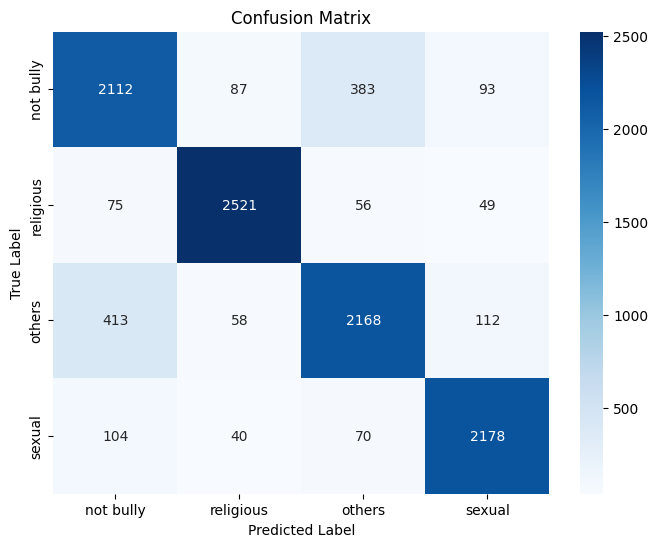

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions and true labels
predictions_output = trainer.predict(test_dataset)
logits = predictions_output.predictions
true_labels = predictions_output.label_ids

predicted_labels = logits.argmax(axis=1)

# Define class names in order
class_names = ['not bully', 'religious', 'others', 'sexual']

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [44]:
import torch

model_path = "distilbert1_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")



Model weights saved to distilbert1_model.pth


In [45]:
torch.save(train_dataset, "distilbert1_train_dataset.pth")


In [46]:
torch.save(test_dataset, "distilbert1_test_dataset.pth")

Evaluating: 100%|████████████████████████████████████████████████████████████████████| 658/658 [00:14<00:00, 46.29it/s]


Macro ROC-AUC Score: 0.9723


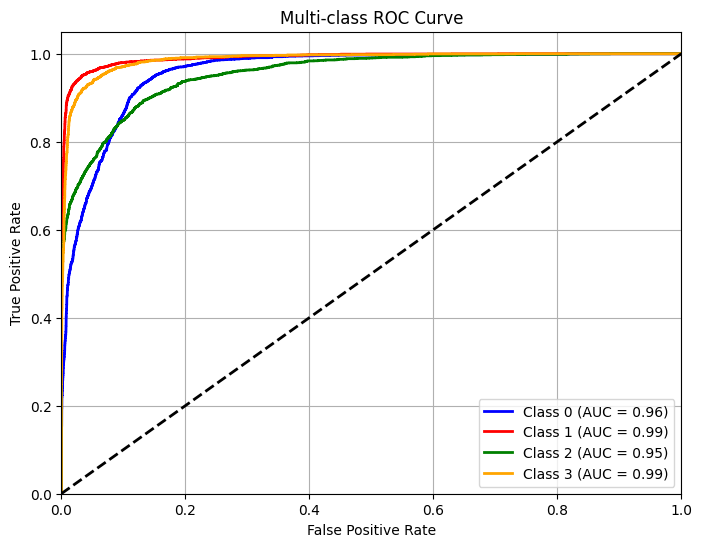

In [47]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_logits(model, dataset, batch_size=16):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_probs, all_labels


# Evaluate
probs, y_true = evaluate_logits(model, test_dataset, batch_size=16)

# Binarize true labels for ROC computation
n_classes = probs.shape[1]
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Compute macro ROC-AUC score
roc_auc_macro = roc_auc_score(y_true_bin, probs, average='macro', multi_class='ovr')
print(f"Macro ROC-AUC Score: {roc_auc_macro:.4f}")


# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
colors = ['blue', 'red', 'green', 'orange']  # customize colors if needed

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()


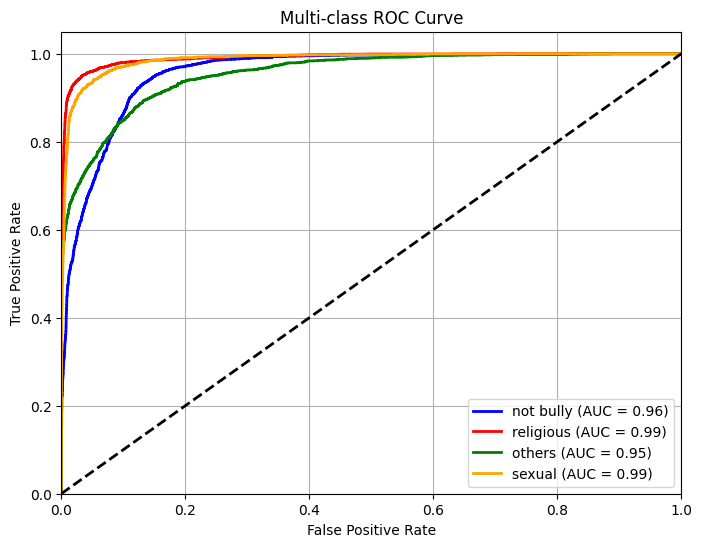

In [48]:
class_names = ['not bully', 'religious', 'others', 'sexual']

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.savefig('distilbert_multi_roc_curve.png')
plt.show()


In [51]:
import os
import torch
model_size_kb = os.path.getsize("distilbert1_model.pth") / 1024
print(f"Model size: {model_size_kb:.0f} KB")



# Count trainable parameters
param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parameter count: {param_count}")


Model size: 528666 KB
Parameter count: 135327748


In [52]:
# Assuming you already have:
# y_true (true labels, shape (n_samples,))
# probs (predicted probabilities, shape (n_samples, n_classes))

# Convert probs to predicted class indices
y_pred = np.argmax(probs, axis=1)

from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa Score: {kappa:.4f}")


Matthews Correlation Coefficient (MCC): 0.8047
Cohen's Kappa Score: 0.8047


In [54]:

torch.save(test_labels, "multi_test_labels.pth")